# Лабораторна робота 3: Знайомство з нейромережами

**Виконав:** Бондар Петро

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from collections import Counter

## Завдання 1: Повнозв'язані нейронні мережі

### Вибір та завантаження датасету
Для виконання цієї лабораторної роботи було обрано датасет з лабораторної роботи 1 (оцінка рівнів ожиріння в людей з Мексико, Перу та Колумбії віком від 14 до 61).

Посилання на датасет: https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster

Виконаємо стандартну обробку датасету.

In [2]:
df_obesity = pd.read_csv('data/ObesityDataSet.csv')
df_obesity = df_obesity.rename(columns={'family_history_with_overweight': 'FAM_OVERWEIGHT', 'NObeyesdad': 'Obesity_level'})
TARGET_VAR = 'Obesity_level'
OTHER_FEATURES = df_obesity.columns.drop(['Obesity_level'])

df_obesity['MTRANS'] = df_obesity['MTRANS'].map({'Walking'               : 0.0, 
                                                 'Bike'                  : 0.15, 
                                                 'Public_Transportation' : 0.5, 
                                                 'Motorbike'             : 0.75, 
                                                 'Automobile'            : 1.0})

FREQ_CATEG_to_NUM = {'Always' : 1.0, 'Frequently' : 0.66, 'Sometimes' : 0.33, 'no' : 0.0}
BIN_CATEG_to_NUM = {'yes' : 1.0, 'no' : 0.0}

df_obesity['CAEC'] = df_obesity['CAEC'].map(FREQ_CATEG_to_NUM)
df_obesity['CALC'] = df_obesity['CALC'].map(FREQ_CATEG_to_NUM)

df_obesity['FAM_OVERWEIGHT'] = df_obesity['FAM_OVERWEIGHT'].map(BIN_CATEG_to_NUM)
df_obesity['FAVC'] = df_obesity['FAVC'].map(BIN_CATEG_to_NUM)
df_obesity['SMOKE'] = df_obesity['SMOKE'].map(BIN_CATEG_to_NUM)
df_obesity['SCC'] = df_obesity['SCC'].map(BIN_CATEG_to_NUM)
df_obesity['Gender'] = df_obesity['Gender'].map({'Male': 1.0, 'Female': 0.0})

OBESITY_TRANSFORM_MAP = {'Insufficient_Weight' : 0,
                         'Normal_Weight'       : 1,
                         'Overweight_Level_I'  : 2,
                         'Overweight_Level_II' : 3,
                         'Obesity_Type_I'      : 4,
                         'Obesity_Type_II'     : 5,
                         'Obesity_Type_III'    : 6}

df_obesity['Obesity_level'] = df_obesity['Obesity_level'].map(OBESITY_TRANSFORM_MAP)


In [3]:
df_obesity.shape
df_obesity.head()

,Gender,Age,Height,Weight,FAM_OVERWEIGHT,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity_level
0,0.0,21.0,1.62,64.0,1.0,0.0,2.0,3.0,0.33,0.0,2.0,0.0,0.0,1.0,0.00,0.5,1
1,0.0,21.0,1.52,56.0,1.0,0.0,3.0,3.0,0.33,1.0,3.0,1.0,3.0,0.0,0.33,0.5,1
2,1.0,23.0,1.80,77.0,1.0,0.0,2.0,3.0,0.33,0.0,2.0,0.0,2.0,1.0,0.66,0.5,1
3,1.0,27.0,1.80,87.0,0.0,0.0,3.0,3.0,0.33,0.0,2.0,0.0,2.0,0.0,0.66,0.0,2
4,1.0,22.0,1.78,89.8,0.0,0.0,2.0,1.0,0.33,0.0,2.0,0.0,0.0,0.0,0.33,0.5,3


### Розбиваємо даніна дві групи: навчання нейромережі та для перевірки, а також нормалізуємо дані по статистикам тренувального набору

In [4]:
from sklearn.preprocessing import StandardScaler

X, y = df_obesity.drop(['Obesity_level'], axis=1), df_obesity['Obesity_level']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1688, 16), (1688,), (423, 16), (423,))

In [5]:
print(f"Imbalance counts in training sample: {Counter(y_train)}")

Imbalance counts in training sample: Counter({4: 300, 6: 256, 5: 247, 2: 231, 3: 223, 0: 216, 1: 215})


### Створюємо модель для класифікації

Вхід: 17 нейронів (X_train.shape[1:])
Параметрів для тренування: 539 655

Для уникнення оверфіттінгу (не те щоб він на такому наборі даних станеться із високою імовірністю), використовуємо Dropout із імовірністю 30%.

Задля інтересу на одному етапі нормалізації явно відключимо навчання (емпіричним методом я дізнався, що це покращило загальний рахунок :D).

In [6]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=X_train.shape[1:]),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.BatchNormalization(trainable=False),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(7, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 543,751 (2.07 MB)

 Trainable params: 539,655 (2.06 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [7]:
model.compile(loss='sparse_categorical_crossentropy',   optimizer='adam', metrics=['accuracy'])

In [8]:
y_train.shape

(1688,)

In [9]:
history = model.fit(X_train,
                    y_train,
                    epochs=12,
                    batch_size=40,                                   
                    validation_data=(X_val, y_val))

Epoch 1/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5361 - loss: 1.4833 - val_accuracy: 0.7376 - val_loss: 1.2888
Epoch 2/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7923 - loss: 0.5726 - val_accuracy: 0.6643 - val_loss: 1.0150
Epoch 3/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8519 - loss: 0.4196 - val_accuracy: 0.7187 - val_loss: 0.8147
Epoch 4/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8663 - loss: 0.3408 - val_accuracy: 0.7400 - val_loss: 0.6547
Epoch 5/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8991 - loss: 0.2987 - val_accuracy: 0.8274 - val_loss: 0.4962
Epoch 6/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9040 - loss: 0.2476 - val_accuracy: 0.8345 - val_loss: 0.4483
Epoch 7/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9174 - loss: 0.2059 - val_accuracy: 0.8794 - val_loss: 0.3632
Epoch 8/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9278 - loss: 0.2018 - val_accuracy: 0.8889 - val_loss:

### Отримуємо результати навчання та тестуємо отриманий результат

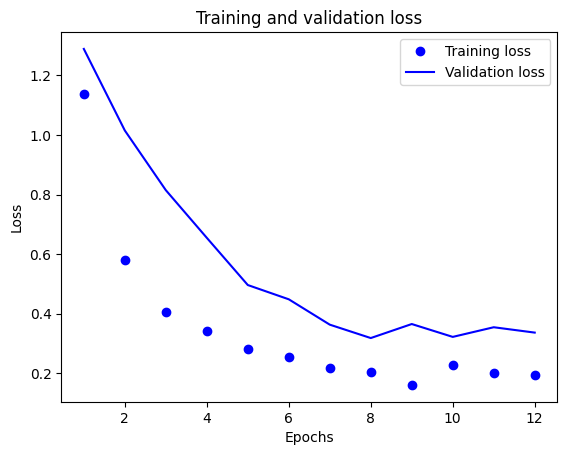

In [10]:
history_dict = history.history
history_dict.keys()

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
score = model.evaluate(X_val, y_val, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.3365303874015808
Test accuracy: 0.9125295281410217


## Завдання 2: Згорткові нейронні мережі

### Вибір та завантаження датасету
Для виконання цього завдання мною було обрано датасет листя виноградної лози. 

Посилання на датасет: https://www.kaggle.com/datasets/muratkokludataset/grapevine-leaves-image-dataset

Датасет містить листя 5 сортів винограду, для кожного з яких є 100 png-зображень розміру 511x511.

In [12]:
# Image params
img_rows, img_cols = 511, 511
input_dim = img_rows * img_cols

leaf_train_ds, leaf_val_ds = keras.preprocessing.image_dataset_from_directory(
    'data/Grapevine_Leaves_Image_Dataset',
    labels='inferred',
    label_mode='int',
    image_size=(img_rows, img_cols),
    batch_size=50,
    validation_split=0.2,
    subset='both',
    seed=65
)

CLASS_NAMES = leaf_train_ds.class_names
print(f"{len(CLASS_NAMES)} classes: {CLASS_NAMES}")

Found 500 files belonging to 5 classes.
Using 400 files for training.
Using 100 files for validation.
5 classes: ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']


### Нормалізуємо данні (поділимо значення пікселів на 255)

In [13]:
normalization_layer = layers.Rescaling(1./255)

def change_inputs(images, labels):
  x = tf.image.resize(normalization_layer(images), [img_rows, img_cols], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return x, labels

leaf_train_ds_norm = leaf_train_ds.map(change_inputs)
leaf_val_ds_norm = leaf_val_ds.map(change_inputs)

### Будуємо модель для тренування з нуля

Використаємо 5 слоїв (Згортка, LeakyReLU та MaxPooling) із кількостями фільтрів від 16 до 256.

In [14]:
alpha = 0.1

model = keras.Sequential([
    layers.Input(shape=(img_rows, img_cols, 3)),

    layers.Conv2D(16, (3, 3), padding="same"),
    layers.LeakyReLU(negative_slope=alpha),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(32, (3, 3), padding="same"),
    layers.LeakyReLU(negative_slope=alpha),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(64, (3, 3), padding="same"),
    layers.LeakyReLU(negative_slope=alpha),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(128, (4, 4), padding="same", strides=2),
    layers.LeakyReLU(negative_slope=alpha),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(256, (3, 3), padding="same"),
    layers.LeakyReLU(negative_slope=alpha),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(512, (3, 3), padding="same"),
    layers.LeakyReLU(negative_slope=alpha),
    layers.MaxPooling2D((3, 3), padding='same'),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),

    layers.Dense(5, activation="softmax")
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 511, 511, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 511, 511, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,992,485 (15.23 MB)

 Trainable params: 3,992,485 (15.23 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_leaf_scratch = model.fit(leaf_train_ds_norm,
                                 validation_data=leaf_val_ds_norm,
                                 epochs=40,
                                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
                                 verbose=1)

score_scratch = model.evaluate(leaf_val_ds_norm, verbose=0) 

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 816ms/step - accuracy: 0.2253 - loss: 1.6860 - val_accuracy: 0.1900 - val_loss: 1.6086
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 785ms/step - accuracy: 0.2124 - loss: 1.6119 - val_accuracy: 0.2300 - val_loss: 1.6084
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 774ms/step - accuracy: 0.2468 - loss: 1.6114 - val_accuracy: 0.1900 - val_loss: 1.6347
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 762ms/step - accuracy: 0.1928 - loss: 1.6151 - val_accuracy: 0.1700 - val_loss: 1.6099
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 784ms/step - accuracy: 0.2021 - loss: 1.6089 - val_accuracy: 0.1800 - val_loss: 1.6115
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 776ms/step - accuracy: 0.2016 - loss: 1.6071 - val_accuracy: 0.1900 - val_loss: 1.6081
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 768ms/step - accuracy: 0.1920 - loss: 1.6030 - val_accuracy: 0.1900 - val_loss: 1.5822
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 774ms/step - accuracy: 0.2256 - loss: 1.5745 - val_accuracy: 0.2500 - val_loss:

### Будуємо модель за допомогою переносу вже попередньо натренованих ваг

In [16]:
leaf_train_ds_norm = leaf_train_ds_norm.prefetch(buffer_size=tf.data.AUTOTUNE)
leaf_val_ds_norm = leaf_val_ds_norm.prefetch(buffer_size=tf.data.AUTOTUNE)

Оберемо EfficientNetB0 як базову мережу натреновану на imagenet.

In [17]:
from tensorflow.keras.applications import EfficientNetB2
base_model = EfficientNetB2(weights='imagenet', input_shape=(img_rows, img_cols, 3), include_top=False)
base_model.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-1].trainable = True

In [18]:
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ (None, 16, 16, 1408)   │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,949,566 (30.33 MB)

 Trainable params: 183,813 (718.02 KB)

 Non-trainable params: 7,765,753 (29.62 MB)

In [19]:
history_leaf_effB = model.fit(leaf_train_ds_norm,
                              validation_data=leaf_val_ds_norm,
                              epochs=40,
                              callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
                              verbose=1)

score_effB = model.evaluate(leaf_val_ds_norm, verbose=0) 

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.2525 - loss: 1.6336 - val_accuracy: 0.2400 - val_loss: 1.6775
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.1871 - loss: 1.6257 - val_accuracy: 0.1700 - val_loss: 1.7154
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.1437 - loss: 1.6385 - val_accuracy: 0.1700 - val_loss: 1.7739
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.1962 - loss: 1.6281 - val_accuracy: 0.1700 - val_loss: 1.6908
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.1492 - loss: 1.6300 - val_accuracy: 0.2400 - val_loss: 1.6307
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.1854 - loss: 1.6186 - val_accuracy: 0.1700 - val_loss: 1.6840
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.1973 - loss: 1.6189 - val_accuracy: 0.1700 - val_loss: 1.6738
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.2094 - loss: 1.6106 - val_accuracy: 0.1700 - val_loss: 1.6778
Epoch 9/

### Порівняння підходів до навчання

In [20]:
manual_history_dict = history_leaf_scratch.history
pretrained_history_dict = history_leaf_effB.history

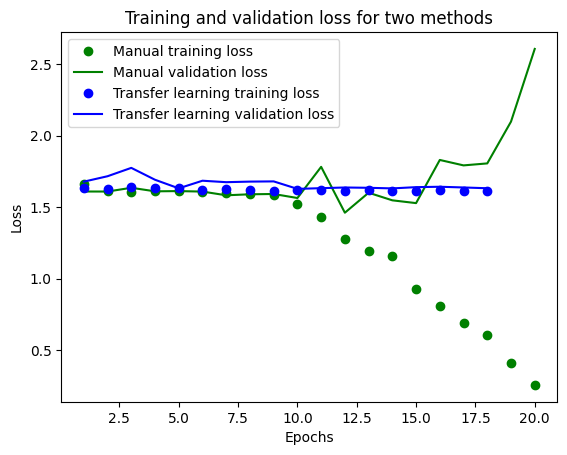

In [25]:
manual_loss = manual_history_dict["loss"]
manual_val_loss = manual_history_dict["val_loss"]

pretrained_loss = pretrained_history_dict["loss"]
pretrained_val_loss = pretrained_history_dict["val_loss"]


epochs = range(1, max(len(manual_loss), len(pretrained_loss)) + 1)
plt.plot(epochs, manual_loss, "go", label="Manual training loss")
plt.plot(epochs, manual_val_loss, "g", label="Manual validation loss")
plt.plot(epochs[:-2], pretrained_loss, "bo", label="Transfer learning training loss")
plt.plot(epochs[:-2], pretrained_val_loss, "b", label="Transfer learning validation loss")
plt.title("Training and validation loss for two methods")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

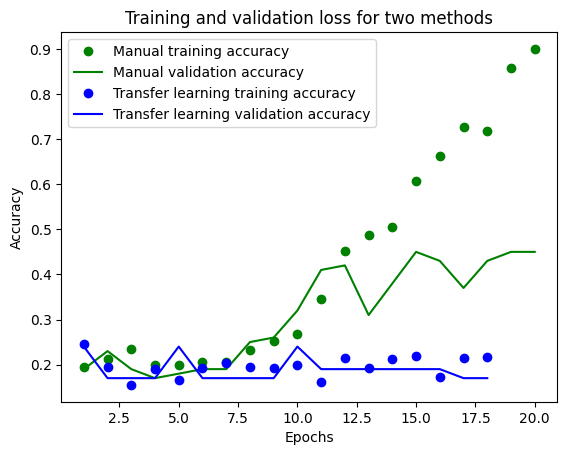

In [27]:
manual_accuracy = manual_history_dict["accuracy"]
manual_val_accuracy = manual_history_dict["val_accuracy"]

pretrained_accuracy = pretrained_history_dict["accuracy"]
pretrained_val_accuracy = pretrained_history_dict["val_accuracy"]


epochs = range(1, max(len(manual_accuracy), len(pretrained_accuracy)) + 1)
plt.plot(epochs, manual_accuracy, "go", label="Manual training accuracy")
plt.plot(epochs, manual_val_accuracy, "g", label="Manual validation accuracy")
plt.plot(epochs[:-2], pretrained_accuracy, "bo", label="Transfer learning training accuracy")
plt.plot(epochs[:-2], pretrained_val_accuracy, "b", label="Transfer learning validation accuracy")
plt.title("Training and validation loss for two methods")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [28]:
print("Scores compare:")
print(f"From scratch: {score_scratch}")
print(f"Transfer learning: {score_effB}")

Scores compare:
From scratch: [1.460432767868042, 0.41999998688697815]
Transfer learning: [1.6270419359207153, 0.23999999463558197]


## Завдання 3: Рекурентні нейронні мережі

### Завантаження датасету

Для цього завдання необхідно було використати датасет із лабораторної роботи 2 (Відгуки про додаток Spotify з Google Play Store за проміжок Січня-Липня 2022 року. Класи (мітки): негативне/позитивне забарвлення відгуку).

Посилання: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset

Використаємо функціонал для токенізації аналогічний до лабораторної номер 2.

In [29]:
from nltk import download
from tensorflow.keras.preprocessing.text import Tokenizer

from nltk.corpus import stopwords
from string import punctuation
import re

download('stopwords', quiet=True)

def clean_line(line, stop_words):
    """Clean text from numbers, punctuation and stop words"""
    line = line.lower()
    line = re.sub(r'@\S+', ' ', line)
    line = re.sub(r'https*\S+', ' ', line)
    line = re.sub(r'#\S+', ' ', line)
    line = re.sub(r'\d', ' ', line)
    line = re.sub(r'[%s]' % re.escape(punctuation), ' ', line)
    line = re.sub(r'\n', ' ', line)
    line = re.sub(r'\s{2,}',' ', line)
    line = ' '.join([token for token in line.split(' ') if token not in stop_words])
    return line

#### Прочитаємо датасет, почистимо та токенізуємо його, після чого додамо паддінг

In [30]:
df_spotify = pd.read_csv('data/SpotifyReviews.csv')
df_spotify = df_spotify.dropna()

X, y = df_spotify['Review'], df_spotify['label']

print(df_spotify['Review'][0])
print(df_spotify['label'][0])

print(f"Imbalance counts in training sample: {Counter(df_spotify['label'])}")

stop_words = stopwords.words('english')
df_spotify['Review'] = df_spotify['Review'].map(lambda line: clean_line(line, stop_words))

Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.
POSITIVE
Imbalance counts in training sample: Counter({'NEGATIVE': 29423, 'POSITIVE': 23263})


In [31]:
max_features = 10000 # max amount of vords in vocabulary
text_tokenizer = Tokenizer(num_words=max_features, oov_token='_\x00?')
text_tokenizer.fit_on_texts(X)
word_index = dict(sorted(text_tokenizer.word_index.items(), key=lambda i: i[1])[:max_features]) # take top <max_features> as word index

In [32]:
X_tokenized = text_tokenizer.texts_to_sequences(X)
print(X[0])
print(X_tokenized[0])
print(len(X_tokenized[0]))

Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.
[41, 10, 146, 2, 286, 9, 598, 157, 5, 2, 7, 9, 123, 4, 53, 86, 52, 1126, 5, 608, 376]
21


In [33]:
X_tokenized_and_padded = keras.utils.pad_sequences(X_tokenized, maxlen=80, padding='post', truncating='post')

print(len(X_tokenized_and_padded[0]))

80


Також перетворимо мітки на числові значення (негативні -> 0, позитивні -> 1) для коректної роботи алгоритму.

In [34]:
y = np.asarray(y.map({'NEGATIVE': 0.0, 'POSITIVE': 1.0})).astype("float64")

#### Розбиваємо відформатовані дані на навчальні на валідаційні зразки

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_tokenized_and_padded, y, test_size=0.2)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((42148, 80), (42148,), (10538, 80), (10538,))

### Навчання мережі та embedding шару з нуля (from scratch)

In [36]:
emb_dim = 128

model_manual = keras.Sequential([
    layers.Embedding(max_features, emb_dim),
    layers.LSTM(128),
    layers.Dense(1, activation="sigmoid")
])

model_manual.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [37]:
history_manual = model_manual.fit(X_train,
                                  y_train,
                                  epochs=10,
                                  batch_size=164,
                                  validation_data=(X_val, y_val),
                                  shuffle = True,
                                  verbose = 1)

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.6144 - loss: 0.6487 - val_accuracy: 0.6171 - val_loss: 0.6338
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.6950 - loss: 0.5646 - val_accuracy: 0.8541 - val_loss: 0.3584
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8672 - loss: 0.3282 - val_accuracy: 0.8676 - val_loss: 0.3215
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8952 - loss: 0.2683 - val_accuracy: 0.8813 - val_loss: 0.3020
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9142 - loss: 0.2254 - val_accuracy: 0.8756 - val_loss: 0.3069
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9213 - loss: 0.2108 - val_accuracy: 0.8863 - val_loss: 0.2974
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9325 - loss: 0.1813 - val_accuracy: 0.8842 - val_loss: 0.2914
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9426 - loss: 0.1586 - 

In [38]:
model_manual.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (164, 80, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (164, 128)             │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (164, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,235,141 (16.16 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,823,428 (10.77 MB)

### Навчання мережі використовуючи pretrained word embeddings

Використаємо натреновані ембеддінги GloVe.
В прикладі розглядався ембеддінг на розмірність 100, а я вирішив заради інтересу взяти на 200. :D

In [39]:
embedding_dim = 200
path_to_glove_file = "glove.6B.200d.txt"

embeddings_index = {}
with open(path_to_glove_file, mode='r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=np.float32, sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [40]:
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

Converted 8472 words (1528 misses)


In [41]:
model_pretrained = keras.Sequential([
    layers.Embedding(max_features, embedding_dim, trainable=False, weights=[embedding_matrix]),
    layers.LSTM(128),
    layers.Dense(1, activation="sigmoid")
])

model_pretrained.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [42]:
history_pretrained = model_pretrained.fit(X_train,
                                          y_train,
                                          epochs=10,
                                          batch_size=164,
                                          validation_data=(X_val, y_val),
                                          shuffle = True,
                                          verbose = 1)

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.6980 - loss: 0.5809 - val_accuracy: 0.8504 - val_loss: 0.3682
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.8611 - loss: 0.3401 - val_accuracy: 0.8793 - val_loss: 0.3056
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.8858 - loss: 0.2909 - val_accuracy: 0.8854 - val_loss: 0.2771
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.8960 - loss: 0.2650 - val_accuracy: 0.8904 - val_loss: 0.2612
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9010 - loss: 0.2508 - val_accuracy: 0.8985 - val_loss: 0.2428
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9075 - loss: 0.2339 - val_accuracy: 0.8987 - val_loss: 0.2405
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9151 - loss: 0.2184 - val_accuracy: 0.9018 - val_loss: 0.2341
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9164 - loss: 0.2152 - 

In [43]:
model_pretrained.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (164, 80, 200)         │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (164, 128)             │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (164, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,505,733 (9.56 MB)

 Trainable params: 168,577 (658.50 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

 Optimizer params: 337,156 (1.29 MB)

### Порівняння підходів до навчання

In [44]:
manual_history_dict = history_manual.history
pretrained_history_dict = history_pretrained.history

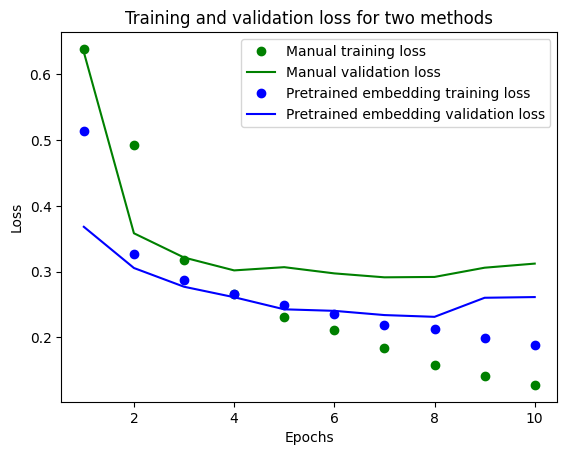

In [45]:
manual_loss = manual_history_dict["loss"]
manual_val_loss = manual_history_dict["val_loss"]

pretrained_loss = pretrained_history_dict["loss"]
pretrained_val_loss = pretrained_history_dict["val_loss"]


epochs = range(1, len(manual_loss) + 1)
plt.plot(epochs, manual_loss, "go", label="Manual training loss")
plt.plot(epochs, manual_val_loss, "g", label="Manual validation loss")
plt.plot(epochs, pretrained_loss, "bo", label="Pretrained embedding training loss")
plt.plot(epochs, pretrained_val_loss, "b", label="Pretrained embedding validation loss")
plt.title("Training and validation loss for two methods")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

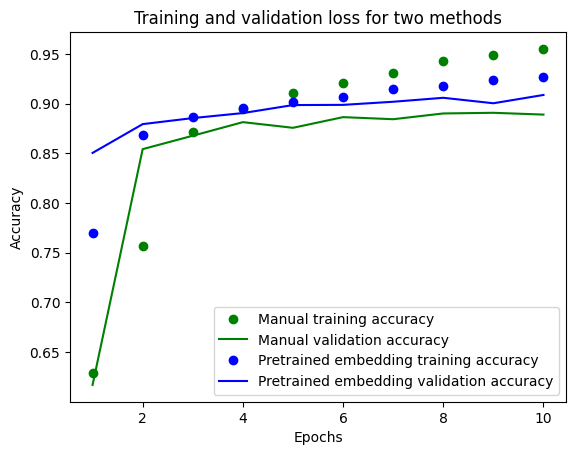

In [46]:
manual_accuracy = manual_history_dict["accuracy"]
manual_val_accuracy = manual_history_dict["val_accuracy"]

pretrained_accuracy = pretrained_history_dict["accuracy"]
pretrained_val_accuracy = pretrained_history_dict["val_accuracy"]


epochs = range(1, len(manual_accuracy) + 1)
plt.plot(epochs, manual_accuracy, "go", label="Manual training accuracy")
plt.plot(epochs, manual_val_accuracy, "g", label="Manual validation accuracy")
plt.plot(epochs, pretrained_accuracy, "bo", label="Pretrained embedding training accuracy")
plt.plot(epochs, pretrained_val_accuracy, "b", label="Pretrained embedding validation accuracy")
plt.title("Training and validation loss for two methods")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()